In [1]:
using LinearAlgebra
using Statistics
using IterativeSolvers
using Convex
using SCS
using COSMO
using NLsolve
using DifferentialEquations
using SparseArrays
using Random
using GraphPlot
using MathOptInterface
using DelimitedFiles
using Colors
using Cairo, Compose

using JLD2

using LightGraphs
using PyPlot
PyPlot.svg(true);

In [42]:
function load_cdf(fname)
    # load graph given in IEEE cdf format
    buslines = []
    branchlines = []
    
    open(fname) do file
        state = :nothing
        for (i, line) in enumerate(eachline(file))
            # where in the file are we? set our state accordingly
            if startswith(line, "BUS DATA FOLLOWS")
                state = :bus
                continue
            end
            
            if startswith(line, "BRANCH DATA FOLLOWS")
                state = :branch
                continue
            end   
            
            if startswith(line, "-999")
                state = :nothing
                continue
            end
            
            # separate data 
            if state == :bus
                push!(buslines, line)
            elseif state == :branch
                push!(branchlines, line)
            end
        end
    end
    
    # relevant bus data
    io = IOBuffer(join(buslines, "\n"))
    busdata = readdlm(io)
    close(io)
    
    voltage = busdata[:,8]
    angle = busdata[:,9]
    load_mw = busdata[:,10]
    load_mvar = busdata[:,11]
    gen_mw = busdata[:,12]
    gen_mvar = busdata[:,13]
    
    # relevant branch data
    io = IOBuffer(join(branchlines, "\n"))
    branchdata = readdlm(io, Any)
    close(io)
    
    branch_a = branchdata[:,1]
    branch_b = branchdata[:,2]
    branch_type = branchdata[:,6]
    
    branch_R = branchdata[:,7]
    branch_X = branchdata[:,8]
    
    branch_B = branch_X./(branch_R.^2 + branch_X.^2)
    
    # construct graph
    g = Graph(length(voltage))
    K = Float64[]
    for (a, b, t, B) in zip(branch_a, branch_b, branch_type, branch_B)
        if t == 0 # transmission line
            add_edge!(g, a, b)
            push!(K, B)#*abs(voltage[a]*voltage[b]))
        end
    end
    
    P = load_mw - gen_mw
    P .-= mean(P)
    
    g, K, P
end

g, K, ω = load_cdf("ieee14cdf.txt")

({14, 20} undirected simple Int64 graph, [15.26308652317955, 4.234983682334831, 4.781863151757718, 5.115838325872082, 5.193927397969713, 5.0688169775939205, 21.578553981691588, 4.781943381790359, 1.7979790715236075, 3.9679390524561544, 4.0940743442404415, 3.1759639650294, 6.102755448193115, 5.676979846721544, 9.090082719752749, 10.365394127060915, 3.0290504569306034, 4.402943749460521, 2.251974626172212, 2.314963475105352], [-231.44285714285715, -17.34285714285714, 95.15714285714286, 48.75714285714285, 8.557142857142857, 12.157142857142857, 0.9571428571428574, 0.9571428571428574, 30.45714285714286, 9.957142857142857, 4.457142857142857, 7.057142857142857, 14.457142857142857, 15.857142857142858])

In [43]:
N = nv(g)
# add_edge!(g, (1, 2))
# add_edge!(g, (3, 2))

# balanced power flows/natural frequencies
# ω = randn(nv(g))
# ω .-= mean(ω)
ω = ω./std(ω);

is_connected(g)

true

In [44]:
function distance_matrix(g)
    dists = zeros(N, N)

    for i=1:N
        sp = LightGraphs.dijkstra_shortest_paths(g, [i])
        dists[i,:] .= sp.dists
    end
    
    dists
end

dists = distance_matrix(g);

In [45]:
function optimize_graph(g, K, ω)
    N = nv(g)

    E = incidence_matrix(g; oriented=true)

    # coupling constants
    B = K #(K/mean(degree(g)))*ones(ne(g));

    # laplacian
    L = Symmetric(E*diagm(0=>B)*E')

    # u, Q = eigen(L)

    L_sp = dropzeros(sparse(L))

    function f_steady_state(F, δ)
        F .= ω/N - E*(B.*sin.(E'*δ))
    end

    # initial condition
    δ0 = 1e-6randn(nv(g))
    sln = nlsolve(f_steady_state, δ0; autodiff=:forward)

    # order parameter at the fixed point
    R0 = abs2(mean(exp.(1im*sln.zero)))

    # check by solving ODE
    function f_kuramoto(du, u, p, t)
        f_steady_state(du, u)
    end

    # Noisy extension
    δbar = sln.zero

    # construct S matrix
    h = complete_graph(nv(g))
    Eh = incidence_matrix(h; oriented=true)
    cosδbar = cos.(Eh'*δbar)
    # cosδbar = ones(ne(h))

    # Laplacian of the corresponding complete graph
    S = Symmetric(-Eh*diagm(0=>cosδbar)*Eh'/nv(g)^2)

    # weighted Laplacian expanded around fixed point
    B_fp = cos.(E'*δbar).*B
    L_fp = Symmetric(E*diagm(0 => B_fp)*E')
    
    # optimize!
    Eq = Convex.Semidefinite(nv(g))
    C = Convex.Semidefinite(nv(g))

    problem = maximize(tr(S*Eq), [
            L_fp*Eq + Eq*L_fp == C, 
            Eq*ones(N) == zeros(N),
    #         sum(Eq) == 0.0,
            diag(C, 0) == 1.0,
    #         tr(C) == nv(g),
            ])
    
    Convex.solve!(problem, () -> COSMO.Optimizer(verbose=false, 
            eps_abs=1e-7, eps_rel=1e-7, max_iter=20000))
    
    @show R0, converged(sln)
    @show problem.optval, problem.status
    
    if (problem.status == MathOptInterface.OPTIMAL) && converged(sln)
        C.value, Eq.value, S, L_fp, R0, problem.optval, δ0, δbar, f_kuramoto
    else
        [NaN], [NaN], [NaN], [NaN], NaN, NaN, NaN, NaN, nothing
    end
end

optimize_graph (generic function with 1 method)

In [46]:
Copt, Eopt, S, L_fp, R0, optval, δ0, δbar, f_kuramoto = optimize_graph(g, K, ω)

(R0, converged(sln)) = (0.9999091617934693, true)
(problem.optval, problem.status) = (-0.030971807946931256, MathOptInterface.OPTIMAL)


([1.00000000033796 -0.8228822110632172 … 0.803154465667994 -0.6566642382058189; -0.8228822109854789 1.0000000002978038 … -0.999425882393726 0.9688933837337026; … ; 0.8031544656878485 -0.9994258823771041 … 1.0000000003108735 -0.9767233481210367; -0.656664238196571 0.9688933837418329 … -0.976723348076974 1.0000000003119802], [0.017871716842817856 -0.007262050352675681 … 0.017315352994952595 -0.01280156863372927; -0.007262050362790602 0.012808098835269847 … -0.016790972102262925 0.016554029016010954; … ; 0.017315352996365503 -0.016790972095870597 … 0.03988101847604314 -0.04109176224717427; -0.012801568632204816 0.016554029017733025 … -0.04109176225462771 0.06497951011683874], [-0.0663005447668681 0.005101782503191903 … 0.005099340603779411 0.005098972038455236; 0.005101782503191903 -0.0663150651077415 … 0.005100752514947468 0.005100494270728937; … ; 0.005099340603779411 0.005100752514947468 … -0.0663213830089388 0.00510202902763786; 0.005098972038455236 0.005100494270728937 … 0.0051020290

In [47]:
(δbar .- δbar[1])*180/π

14-element Vector{Float64}:
 0.0
 0.5765550003973953
 1.4509753709572983
 1.2062900129672376
 1.035787320382616
 1.692255505732387
 1.5921936047160816
 1.6017994170381589
 1.7832033500202087
 1.8237212094058537
 1.7902635773517215
 1.8376519096874278
 1.8641626280008217
 1.987330800823711

In [48]:
@show sum(abs.(Copt))/N^2
@show sum(Eopt)
@show norm(Eopt*ones(N))

# optimal solution
optval

sum(abs.(Copt)) / N ^ 2 = 0.49566741608181797
sum(Eopt) = -5.344974463028507e-12
norm(Eopt * ones(N)) = 3.4544620512731214e-11


-0.030971807946931256

In [49]:
# compare to uniform noise
C_unif = ((1 + 1/nv(g))I - ones(nv(g), nv(g))/nv(g))

E_uf = lyap(Array(L_fp), -C_unif)

optval_uniform = tr(E_uf*S)

@show optval_uniform
@show optval_uniform/optval

LoadError: LAPACKException(1)

In [58]:
P = zeros(N-1, N)
for i=1:N-1
    P[i,1] = 1/sqrt(2)
    P[i,i+1] = -1/sqrt(2)
end

# projector matrix onto orth complement of 1
P

13×14 Matrix{Float64}:
 0.707107  -0.707107   0.0       …   0.0        0.0        0.0
 0.707107   0.0       -0.707107      0.0        0.0        0.0
 0.707107   0.0        0.0           0.0        0.0        0.0
 0.707107   0.0        0.0           0.0        0.0        0.0
 0.707107   0.0        0.0           0.0        0.0        0.0
 0.707107   0.0        0.0       …   0.0        0.0        0.0
 0.707107   0.0        0.0           0.0        0.0        0.0
 0.707107   0.0        0.0           0.0        0.0        0.0
 0.707107   0.0        0.0           0.0        0.0        0.0
 0.707107   0.0        0.0           0.0        0.0        0.0
 0.707107   0.0        0.0       …  -0.707107   0.0        0.0
 0.707107   0.0        0.0           0.0       -0.707107   0.0
 0.707107   0.0        0.0           0.0        0.0       -0.707107

In [55]:
# compare to uniform noise
C_unif = ((1 + 1/nv(g))I - ones(nv(g), nv(g))/nv(g))

# project on subspace 1^⟂
L0 = P*L_fp*P'
C0 = P*C_unif*P'
S0 = P*S*P'

E_uf = lyap(L0, -C0)

optval_uniform = tr(E_uf*S0)

@show optval_uniform
@show optval_uniform/optval

optval_uniform = -0.048219991864076675
optval_uniform / optval = 1.5568994857096936


13×13 Matrix{Float64}:
 1.07143   0.535714  0.535714  0.535714  …  0.535714  0.535714  0.535714
 0.535714  1.07143   0.535714  0.535714     0.535714  0.535714  0.535714
 0.535714  0.535714  1.07143   0.535714     0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  1.07143      0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714     0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714  …  0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714     0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714     0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714     0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714     0.535714  0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714  …  1.07143   0.535714  0.535714
 0.535714  0.535714  0.535714  0.535714     0.535714  1.07143   0.535714
 0.535714  0.535714  0.535714  0.535714     0.535714  0.535714  1.07143

In [86]:
# compare to uniform noise
C_unif = ((1 + 1/nv(g))I - ones(nv(g), nv(g))/nv(g))

# project on subspace 1^⟂
u, V = eigen(Array(L_fp))

V0 = V[2:end,:]
L0 = V0*L_fp*V0'
C0 = V0*C_unif*V0'
S0 = V0*S*V0'

E_uf = lyap(L0, -C0)

optval_uniform = tr(E_uf*S0)

@show optval_uniform
@show optval_uniform/optval

optval_uniform = -0.05367802895630433
optval_uniform / optval = 1.7331254619775223


1.7331254619775223

In [64]:
# jldsave("data/ieee_$(N)_fix_Cii.jld2"; g, K, δ0, δbar, R0, Copt, Eopt, optval, optval_uniform)

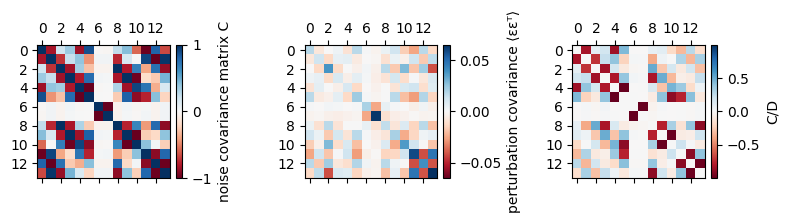

In [65]:
fig, axs = subplots(1, 3, figsize=(8, 2.5))

ax = axs[1]
cmin, cmax = abs(minimum(Copt)), abs(maximum(Copt))
cm = maximum([cmin, cmax])
sc = ax.matshow(Copt, cmap="RdBu", vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="noise covariance matrix C")

ax = axs[2]
cmin, cmax = abs(minimum(Eopt)), abs(maximum(Eopt))
cm = maximum([cmin, cmax])
sc = ax.matshow(Eopt, cmap="RdBu", vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="perturbation covariance ⟨εεᵀ⟩")

ax = axs[3]

CD = Copt./dists
CD[.!isfinite.(CD)] .= 0.0
cmin, cmax = abs(minimum(CD)), abs(maximum(CD))
cm = maximum([cmin, cmax])
sc = ax.matshow(CD, cmap="RdBu", vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="C/D")

fig.tight_layout()

In [66]:
cmin, cmax

(0.9981802503657636, 0.4994915068480137)

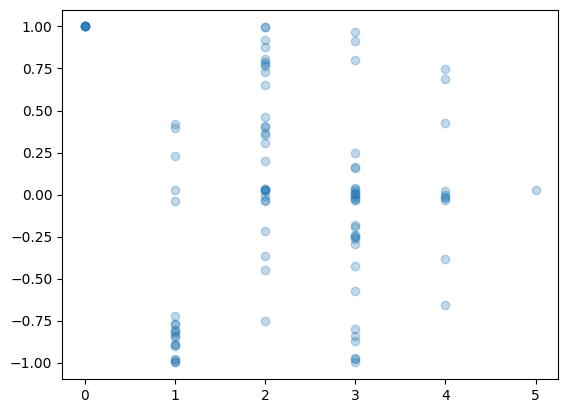

PyObject <matplotlib.collections.PathCollection object at 0x7fd94ae834c0>

In [67]:
fig, ax = subplots()

ax.scatter(distance_matrix(g)[:], Copt[:], alpha=0.15)

In [68]:
# find a particular realization of the noise input
function G_from_C(C)
    U, Σ, V = svd(C)
    U*diagm(0 => sqrt.(Σ))*U'
end

G = G_from_C(Copt)
η = G*randn(nv(g));

In [69]:
# run a SDE solution to check results

function solve_sde(σ, δ0, G; tspan=(0.0, 3000.0), dt=0.01)
    # σ is the noise strength (multiplies the noise matrix)
    function g_kuramoto(du, u, p, t)
        du .= 1/sqrt(2)*σ*G
    end
    
    prob = SDEProblem(f_kuramoto, g_kuramoto, δ0, tspan; noise_rate_prototype=zeros(size(G)...))
    sdesln = solve(prob, EM(), dt=dt)
end

function cumtrapz_avg(t::T, Y::T) where {T <: AbstractVector}
    # Estimates the cumulative time average integral 1/T ∫₀ᵀ f(t) dt using the trapezoid rule
    # where time points are in t and corresponding samples of f are in Y
    
    # Check matching vector length
    @assert length(t) == length(Y)
    
    # Initialize Output
    out = similar(t)
    out[1] = 0.0
    # Iterate over arrays
    for i in 2:length(t)
        out[i] = out[i-1] + 0.5*(t[i] - t[i-1])*(Y[i] + Y[i-1])
    end
    out[2:end] ./= (t[2:end] .- t[1])
    out[1] = out[2]

    out
end

function Rsqr_from_sde(sdesln)
    # numerically integrate and average
    Rsqrs = [abs(mean(exp.(1im*u)))^2 for u in sdesln.u]
end

Rsqr_from_sde (generic function with 1 method)

In [70]:
σ = 0.25
G = G_from_C(Copt)

sdesln = solve_sde(σ, δbar, G; tspan=(0.0, 5000.0))
Rsqrs_sde = Rsqr_from_sde(sdesln);
Rsqrs_avg = cumtrapz_avg(sdesln.t, Rsqrs_sde);

In [71]:
G_unif = G_from_C(C_unif)

sdesln_unif = solve_sde(σ, δbar, G_unif; tspan=(0.0, 5000.0))
Rsqrs_sde_unif = Rsqr_from_sde(sdesln_unif);
Rsqrs_avg_unif = cumtrapz_avg(sdesln_unif.t, Rsqrs_sde_unif);

In [72]:
ts = sdesln.t
ts_unif = sdesln_unif.t

# jldsave("data/ieee_$(N)_timeseries.jld2"; Rsqrs_avg, Rsqrs_avg_unif, ts, ts_unif, σ, G)

500001-element Vector{Float64}:
    0.0
    0.01
    0.02
    0.03
    0.04
    0.05
    0.060000000000000005
    0.07
    0.08
    0.09
    0.09999999999999999
    0.10999999999999999
    0.11999999999999998
    ⋮
 4999.890000062715
 4999.900000062716
 4999.910000062716
 4999.920000062716
 4999.930000062716
 4999.9400000627165
 4999.950000062717
 4999.960000062717
 4999.970000062717
 4999.980000062717
 4999.990000062718
 5000.0

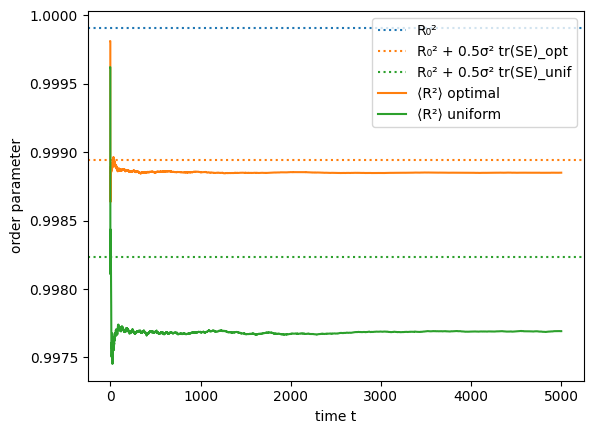

PyObject Text(24.0, 0.5, 'order parameter')

In [87]:
fig, ax = subplots()
ax.axhline(R0, ls=":", label="R₀²")
ax.axhline(R0 + 0.5σ^2*optval, label="R₀² + 0.5σ² tr(SE)_opt", color="C1", ls=":")
ax.axhline(R0 + 0.5σ^2*optval_uniform, label="R₀² + 0.5σ² tr(SE)_unif", color="C2", ls=":")
# ax.axhline(R0 - σ^2*problem.optval)

# ax.set_ylim(R0 - 5σ^2*abs(optval_uniform), R0 + 5σ^2*abs(optval_uniform))

# ax.plot(Rsqrs_sde, alpha=0.5)
ax.plot(sdesln.t, Rsqrs_avg, color="C1", label="⟨R²⟩ optimal")
ax.plot(sdesln_unif.t, Rsqrs_avg_unif, color="C2", label="⟨R²⟩ uniform")

# ax.set_xlim(150000, 200000)

ax.legend()
ax.set_xlabel("time t")
ax.set_ylabel("order parameter")

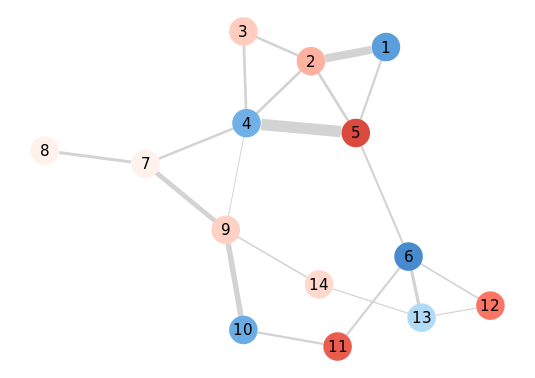

In [84]:
cm = colormap("RdBu")[15:85]

# i = 19
i = 6
cols = Int64.(round.(70*(Copt[i,:]/2 .+ 0.5)))
cols[cols .== 0] .= 1

# edgecols = [colorant"white" for i=1:N]
# cols[i] = 35

layout=(args...)->spring_layout(args...; C=0.5, MAXITER=1500)
p = gplot(g, layout=layout, nodefillc=cm[cols], nodelabel=1:N, edgelinewidth=K, EDGELINEWIDTH=3)

In [85]:
Compose.draw(SVG("ieee$(N).svg"), p)

false